<a href="https://colab.research.google.com/github/RevanthBN/COVID-GANs/blob/main/IDL_Baseline_Class_Weights.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
from matplotlib.pyplot import *
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torchvision import transforms
from torchvision import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from functools import partial
from dataclasses import dataclass
from collections import OrderedDict
import os
from PIL import Image
import torchvision.transforms.functional as TF
import time
from sklearn.svm import SVC
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import roc_auc_score
cuda = torch.cuda.is_available()
cuda

True

In [ ]:
!pip install torchsummary
from torchsummary import summary

In [ ]:
! cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list

ref                                                          title                                           size  lastUpdated          downloadCount  
-----------------------------------------------------------  ---------------------------------------------  -----  -------------------  -------------  
alexgude/california-traffic-collision-data-from-switrs       California Traffic Collision Data from SWITRS    1GB  2020-11-22 16:51:55           1126  
babyoda/women-entrepreneurship-and-labor-force               Women Entrepreneurship and Labor Force           1KB  2020-11-21 08:38:51           2850  
szymonjanowski/internet-articles-data-with-users-engagement  Internet news data with readers engagement       3MB  2020-11-21 17:09:57           1345  
sakshigoyal7/credit-card-customers                           Credit Card customers                          379KB  2020-11-19 07:38:44           5435  
imoore/2020-us-general-election-turnout-rates                2020 US General Election Tu

In [ ]:
!pip install --upgrade --force-reinstall --no-deps kaggle

     |████████████████████████████████| 61kB 4.2MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=710180e66a95a49ba247c4532541f564cf4d63871a8089d0317b1b5351e4f3f9
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.9
    Uninstalling kaggle-1.5.9:
      Successfully uninstalled kaggle-1.5.9


In [ ]:
# ! kaggle competitions download -c yash612/covidnet-mini-and-gan-enerated-chest-xray
! kaggle datasets download -d yash612/covidnet-mini-and-gan-enerated-chest-xray

 99% 1.50G/1.51G [00:19<00:00, 46.5MB/s]
100% 1.51G/1.51G [00:19<00:00, 81.6MB/s]


In [ ]:
! unzip covidnet-mini-and-gan-enerated-chest-xray.zip -d data

**Apply transformation on the images**

In [ ]:
trans_apply=transforms.Compose([transforms.Resize((64,64)),transforms.ToTensor()])

In [ ]:
train_dataset=datasets.ImageFolder('/content/drive/MyDrive/data/chest_xray/chest_xray/train',transform=trans_apply)
val_dataset=datasets.ImageFolder('/content/drive/MyDrive/data/chest_xray/chest_xray/val',transform=trans_apply)
test_dataset=datasets.ImageFolder('/content/drive/MyDrive/data/chest_xray/chest_xray/test',transform=trans_apply)

torch.Size([3, 64, 64])
3


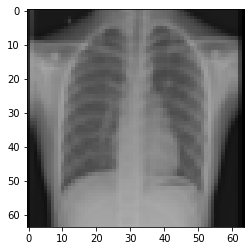

In [ ]:
plt.imshow(np.transpose(test_dataset[100][0],axes=(1,2,0)))
print(train_dataset[1600][0].shape)
print(len(train_dataset.classes))
n_classes=len(train_dataset.classes)

In [ ]:
print("train",train_dataset.__len__(), len(train_dataset.classes))
print("val",val_dataset.__len__(), len(val_dataset.classes))
print("test",test_dataset.__len__(), len(test_dataset.classes))

train 6862 3
val 27 3
test 635 3


In [ ]:
num_workers = 12 if cuda else 0 
    
# Training data
train_loader_args = dict(shuffle=True, batch_size=100, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=800)
train_loader = data.DataLoader(train_dataset, **train_loader_args)

# Validation data
val_loader_args = dict(shuffle=True, batch_size=10, num_workers=num_workers) if cuda\
                    else dict(shuffle=True, batch_size=500)
val_loader = data.DataLoader(val_dataset, **val_loader_args)

# Testing data
test_loader_args = dict(shuffle=False, num_workers=num_workers) if cuda\
                    else dict(shuffle=False,drop_last=True)
test_loader = data.DataLoader(test_dataset, **test_loader_args)


In [ ]:
class Conv2dAuto(nn.Conv2d):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.padding =  (self.kernel_size[0] // 2, self.kernel_size[1] // 2) # dynamic add padding based on the kernel_size
        
conv3x3 = partial(Conv2dAuto, kernel_size=3, bias=False) 

def activation_func(activation):
    return  nn.ModuleDict([
        ['relu', nn.ReLU(inplace=True)],
        ['leaky_relu', nn.LeakyReLU(negative_slope=0.01, inplace=True)],
        ['selu', nn.SELU(inplace=True)],
        ['none', nn.Identity()]
    ])[activation]

class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, activation='relu'):
        super().__init__()
        self.in_channels, self.out_channels, self.activation = in_channels, out_channels, activation
        self.blocks = nn.Identity()
        self.activate = activation_func(activation)
        self.shortcut = nn.Identity()   
    
    def forward(self, x):
        residual = x
        if self.should_apply_shortcut: residual = self.shortcut(x)
        x = self.blocks(x)
        x += residual
        x = self.activate(x)
        return x
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.out_channels

class ResNetResidualBlock(ResidualBlock):
    def __init__(self, in_channels, out_channels, expansion=1, downsampling=1, conv=conv3x3, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.expansion, self.downsampling, self.conv = expansion, downsampling, conv
        self.shortcut = nn.Sequential(
            nn.Conv2d(self.in_channels, self.expanded_channels, kernel_size=1,
                      stride=self.downsampling, bias=False),
            nn.BatchNorm2d(self.expanded_channels, momentum=0.5)) if self.should_apply_shortcut else None
        
        
    @property
    def expanded_channels(self):
        return self.out_channels * self.expansion
    
    @property
    def should_apply_shortcut(self):
        return self.in_channels != self.expanded_channels

def conv_bn(in_channels, out_channels, conv, *args, **kwargs):
    return nn.Sequential(conv(in_channels, out_channels, *args, **kwargs), nn.BatchNorm2d(out_channels,momentum=0.9))

class ResNetBasicBlock(ResNetResidualBlock):
    """
    Basic ResNet block composed by two layers of 3x3conv/batchnorm/activation
    """
    expansion = 1
    def __init__(self, in_channels, out_channels, *args, **kwargs):
        super().__init__(in_channels, out_channels, *args, **kwargs)
        self.blocks = nn.Sequential(
            conv_bn(self.in_channels, self.out_channels, conv=self.conv, bias=False, stride=self.downsampling),
            activation_func(self.activation),
            conv_bn(self.out_channels, self.expanded_channels, conv=self.conv, bias=False),
        )

class ResNetLayer(nn.Module):
    """
    A ResNet layer composed by `n` blocks stacked one after the other
    """
    def __init__(self, in_channels, out_channels, block=ResNetBasicBlock, n=1, *args, **kwargs):
        super().__init__()
        # 'We perform downsampling directly by convolutional layers that have a stride of 2.'
        downsampling = 2 if in_channels != out_channels else 1
        self.blocks = nn.Sequential(
            block(in_channels , out_channels, *args, **kwargs, downsampling=downsampling),
            *[block(out_channels * block.expansion, 
                    out_channels, downsampling=1, *args, **kwargs) for _ in range(n - 1)]
        )

    def forward(self, x):
        x = self.blocks(x)
        return x

class ResNetEncoder(nn.Module):
    """
    ResNet encoder composed by layers with increasing features.
    """
    def __init__(self, in_channels=3, blocks_sizes=[64,128,256,512], deepths=[2,2,2,2], 
                 activation='relu', block=ResNetBasicBlock, *args, **kwargs):
        super().__init__()
        self.blocks_sizes = blocks_sizes
        
        self.gate = nn.Sequential(
            nn.Conv2d(in_channels, self.blocks_sizes[0], kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm2d(self.blocks_sizes[0]),
            activation_func(activation),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )
        
        self.in_out_block_sizes = list(zip(blocks_sizes, blocks_sizes[1:]))
        self.blocks = nn.ModuleList([ 
            ResNetLayer(blocks_sizes[0], blocks_sizes[0], n=deepths[0], activation=activation, 
                        block=block,*args, **kwargs),
            *[ResNetLayer(in_channels * block.expansion, 
                          out_channels, n=n, activation=activation, 
                          block=block, *args, **kwargs) 
              for (in_channels, out_channels), n in zip(self.in_out_block_sizes, deepths[1:])]       
        ])
        
        
    def forward(self, x):
        x = self.gate(x)
        for block in self.blocks:
            x = block(x)
        return x

class ResnetDecoder(nn.Module):
    """
    This class represents the tail of ResNet. It performs a global pooling and maps the output to the
    correct class by using a fully connected layer.
    """
    def __init__(self, in_features, n_classes):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d((1, 1))
        self.decoder = nn.Linear(in_features, n_classes)

    def forward(self, x):
        x = self.avg(x)
        x = x.view(x.size(0), -1)
        embedding=x
        x = self.decoder(x)
        return x,embedding
      


class ResNet(nn.Module):
    
    def __init__(self, in_channels, n_classes, *args, **kwargs):
        super().__init__()
        self.encoder = ResNetEncoder(in_channels, *args, **kwargs)
        self.decoder = ResnetDecoder(self.encoder.blocks[-1].blocks[-1].expanded_channels, n_classes)
        
    def forward(self, x):
        x = self.encoder(x)
        x, embedding = self.decoder(x)
        return x, embedding

In [ ]:
def resnet18(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[2, 2, 2, 2], *args, **kwargs)

def resnet34(in_channels, n_classes, block=ResNetBasicBlock, *args, **kwargs):
    return ResNet(in_channels, n_classes, block=block, deepths=[3, 4, 6, 3], *args, **kwargs)

model18 = resnet18(3, 3)
model34 = resnet34(3,3)
criterion = nn.CrossEntropyLoss()
learningRate = 1e-2
weightDecay = 5e-4
optimizer = torch.optim.SGD(model34.parameters(), lr=learningRate, weight_decay=weightDecay, momentum=0.5)
scheduler=optim.lr_scheduler.ExponentialLR(optimizer,gamma=0.7)
device = torch.device("cuda" if cuda else "cpu")
model18.to(device)
model34.to(device)

ResNet(
  (encoder): ResNetEncoder(
    (gate): Sequential(
      (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    )
    (blocks): ModuleList(
      (0): ResNetLayer(
        (blocks): Sequential(
          (0): ResNetBasicBlock(
            (blocks): Sequential(
              (0): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
              )
              (1): ReLU(inplace=True)
              (2): Sequential(
                (0): Conv2dAuto(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
                (1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=

In [ ]:
summary(model18.cuda(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
        Conv2dAuto-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
        Conv2dAuto-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
 ResNetBasicBlock-11           [-1, 64, 16, 16]               0
       Conv2dAuto-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [ ]:
summary(model34.cuda(), (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           9,408
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
        Conv2dAuto-5           [-1, 64, 16, 16]          36,864
       BatchNorm2d-6           [-1, 64, 16, 16]             128
              ReLU-7           [-1, 64, 16, 16]               0
        Conv2dAuto-8           [-1, 64, 16, 16]          36,864
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
 ResNetBasicBlock-11           [-1, 64, 16, 16]               0
       Conv2dAuto-12           [-1, 64, 16, 16]          36,864
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer):
    model.train()
    model.cuda()
    running_loss = 0.0
    print("Entered Training")
    start_time = time.time()
    for batch_idx, (data, target) in enumerate(train_loader):   
        optimizer.zero_grad()   # .backward() accumulates gradients
        data = data.cuda()
        target = target.cuda() # all data & model on same device

        outputs,embeddings = model(data)
        loss = criterion(outputs, target)
        running_loss += loss.item()

        loss.backward()
        optimizer.step()
    end_time = time.time()
    
    running_loss /= len(train_loader)
    print('Training Loss: ', running_loss, 'Time: ',end_time - start_time, 's')
    return running_loss

def test_model(model, val_loader, criterion):
    with torch.no_grad():
        model.eval()
        print("Entered Evaluation")
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        model.cuda()
        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.cuda()

            outputs,embeddings = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Val Loss: ', running_loss)
        print('Val Accuracy: ', acc, '%')
        return running_loss, acc


In [ ]:
n_epochs = 10
Train_loss = []
Test_loss = []
Test_acc = []

for i in range(n_epochs):
    print("Epoch Number -- ",i+1)
    train_loss = train_epoch(model34, train_loader, criterion, optimizer)
    test_loss, test_acc = test_model(model34, val_loader, criterion)
    # auc=test_verify(model,ver_loader)
    Train_loss.append(train_loss)
    Test_loss.append(test_loss)
    Test_acc.append(test_acc)
    scheduler.step()
    print('='*20)

Epoch Number --  1
Entered Training
Training Loss:  0.2976584586760272 Time:  43.03822660446167 s
Entered Evaluation
Val Loss:  0.576555942495664
Val Accuracy:  85.18518518518519 %
Epoch Number --  2
Entered Training
Training Loss:  0.12672055237319158 Time:  43.63297152519226 s
Entered Evaluation
Val Loss:  1.2166767517725627
Val Accuracy:  74.07407407407408 %
Epoch Number --  3
Entered Training
Training Loss:  0.06175161911633568 Time:  43.66288685798645 s
Entered Evaluation
Val Loss:  0.6234749133388201
Val Accuracy:  77.77777777777779 %
Epoch Number --  4
Entered Training
Training Loss:  0.025636277546215315 Time:  43.49909996986389 s
Entered Evaluation
Val Loss:  0.36998915672302246
Val Accuracy:  85.18518518518519 %
Epoch Number --  5
Entered Training
Training Loss:  0.008679327730467354 Time:  43.23153519630432 s
Entered Evaluation
Val Loss:  0.4124526186690976
Val Accuracy:  88.88888888888889 %
Epoch Number --  6
Entered Training
Training Loss:  0.0054171770065348 Time:  43.362

In [ ]:
def pred(model, test_loader, criterion):
    with torch.no_grad():
        model.eval()
        print("Entered Evaluation")
        running_loss = 0.0
        total_predictions = 0.0
        correct_predictions = 0.0
        model.cuda()
        for batch_idx, (data, target) in enumerate(val_loader):   
            data = data.cuda()
            target = target.cuda()

            outputs,embeddings = model(data)

            _, predicted = torch.max(outputs.data, 1)
            total_predictions += target.size(0)
            correct_predictions += (predicted == target).sum().item()

            loss = criterion(outputs, target).detach()
            running_loss += loss.item()


        running_loss /= len(val_loader)
        acc = (correct_predictions/total_predictions)*100.0
        print('Testing Loss: ', running_loss)
        print('Testing Accuracy: ', acc, '%')
        return running_loss, acc

In [ ]:
test_loss, test_acc = pred(model34, test_loader, criterion)

Entered Evaluation
Testing Loss:  0.2978765284642577
Testing Accuracy:  88.88888888888889 %
